In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

datasets = {}

In [2]:
# Parse data from Yahoo (1950 - now)
# https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC
data = pd.read_csv('SP500-Yahoo-Daily.csv', index_col='Date', parse_dates=['Date'])
data = data.resample('BM').apply(lambda x: x[-1])
data['Yield'] = data['Adj Close'].pct_change().fillna(0.0)
data = data[['Yield']]
data['Inflation'] = 0.02 / 12 # Fixed inflation at 2%, we can do better if we use Shiller's data here

datasets['Yahoo'] = data
print("Data size for Yahoo's S&P 500 data is %d" % len(data.index))
data.tail(4)

Data size for Yahoo's S&P 500 data is 826


,Yield,Inflation
Date,,
2018-07-31,0.036022,0.001667
2018-08-31,0.030263,0.001667
2018-09-28,0.004294,0.001667
2018-10-31,-0.071521,0.001667


In [3]:
# Parse data from Shiller (1870 - now)
# http://www.econ.yale.edu/~shiller/data.htm
data = pd.read_csv("SP500-Shiller.csv", delimiter='\t', index_col='Date')
data['Stock yield'] = data['P'].pct_change().fillna(0.0)
data['Div yield'] = (data['D'] / data['P']).fillna(0.0) / 12 # Shiller uses div yield of trailing 12 months
data['Inflation'] = data['CPI'].pct_change().fillna(0.0)
data['Yield'] =  data['Stock yield'] + data['Div yield']
data = data[['Yield', 'Inflation']]

datasets['Shiller'] = data
print("Data size for Shiller's S&P 500 data is %d" % len(data.index))
data.tail(3)

Data size for Shiller's S&P 500 data is 1774


,Yield,Inflation
Date,,
2018.08,0.024487,0.000556
2018.09,0.016788,0.000278
2018.10,-0.039918,0.000139


In [4]:
def vermogensbelasting_2016(capital, gains=0):
    return max(0, round(0.012 * (capital-(2*24437)))) # met partner

assert vermogensbelasting_2016(0) == 0
assert vermogensbelasting_2016(150000) == 1214 # Belastingdienst.nl voorbeeld

vermogensbelasting_2016(1000000)

11414

In [5]:
# https://www.belastingdienst.nl/wps/wcm/connect/bldcontentnl/belastingdienst/prive/vermogen_en_aanmerkelijk_belang/vermogen/belasting_betalen_over_uw_vermogen/grondslag_sparen_en_beleggen/berekenen_belasting_over_uw_inkomsten_uit_vermogen_vanaf_2017/
def vermogensbelasting_2017(capital, gains=0):
    taxable = capital - 25000
    if taxable <= 0:
        return 0
    
    schijf_1 = min(75000, taxable)
    schijf_2 = max(min(975000, taxable)-75000, 0)
    schijf_3 = max(taxable - 975000, 0)
    
    return round((0.02871 * schijf_1 + 0.04600 * schijf_2 + 0.0539 * schijf_3) * 0.30)

assert vermogensbelasting_2017(0) == 0
assert vermogensbelasting_2017(125000) == 991
assert vermogensbelasting_2017(1250000) == 17108

In [6]:
# https://www.belastingdienst.nl/wps/wcm/connect/bldcontentnl/belastingdienst/prive/vermogen_en_aanmerkelijk_belang/vermogen/belasting_betalen_over_uw_vermogen/grondslag_sparen_en_beleggen/berekening-2018/
def vermogensbelasting_2018(capital, gains=0):
    taxable = capital - 30000
    if taxable < 0:
        return 0
    
    schijf_1 = min(70800, taxable)
    schijf_2 = max(min(978000, taxable)-70800, 0)
    schijf_3 = max(taxable - 978000, 0)
    
    return round((0.02017 * schijf_1 + 0.04326 * schijf_2 + 0.0538 * schijf_3) * 0.30)

assert vermogensbelasting_2018(0) == 0
assert vermogensbelasting_2018(130000) == 807
assert vermogensbelasting_2018(1255000) == 16189

In [7]:
def vennootschapsbelasting(capital, gains):
    schijf_1 = min(200000, gains)
    schijf_2 = max(gains-200000, 0)
    return round(max(0, 0.20 * schijf_1 + 0.25 * schijf_2))

assert vennootschapsbelasting(0, 200000) == 40000

In [8]:
def simulate(initial_capital, withdrawal_rate, duration_in_years=30, tax_fn=None):  
    months = duration_in_years * 12
    run_index = np.arange(0, months)
    initial_data = {'capital': 0.0, 'market_return': 0.0,'withdrawal': 0.0, 'taxes': 0.0}
    
    dataset = datasets['Shiller']
    n = len(dataset.index)    
    results = pd.DataFrame(index=np.arange(0, n - months), data={'end_value': 0.0})

    for p in results.index:
        run = pd.DataFrame(index=run_index, data=initial_data)
        run.index.name = 'month'

        capital = initial_capital
        withdrawal = withdrawal_rate / 12 * initial_capital 

        # loop over months
        for m in run.index:
            i = m + p
            row = dataset.iloc[i]
            market_return = row['Yield']
            gain = capital * market_return

            # pay taxes every 12th month
            taxes = 0
            if m % 12 == 0 and tax_fn:
                taxes = tax_fn(capital, gain)

            run.at[m, 'capital'] = capital
            run.at[m, 'market_return'] = market_return
            run.at[m, 'withdrawal'] = withdrawal
            run.at[m, 'taxes'] = taxes     

             # withdraw inflation adjusted WR amount
            capital -= withdrawal

            # calculate inflation adjusted withdrawal amount
            withdrawal = withdrawal * ( 1 + row['Inflation'] )

            # add capital gains
            capital += gain

            # pay taxes
            capital -= taxes

            # at the end of simulation, add to results dataframe
            if m == months-1:
                results.at[p, 'end_value'] = capital
    
    return results

def success_rate(results, min_capital=0):
    return results[results['end_value'] > min_capital].size / results.size

In [9]:
# Tax-free simulation with a 4% withdrawal rate over 30 years. 
# Should yield a success rate of about 98% (to match the Trinity study results)
res = simulate(1000000, 0.04, 30)
print("End value was higher than 0 in {0:.0%} of all simulations".format(success_rate(res, min_capital=0)))
print("End value was higher than initial capital (adjusted for inflation) in {0:.0%} of all simulations".format(success_rate(res, min_capital=1000000*pow(1.02, 30))))

End value was higher than 0 in 98% of all simulations
End value was higher than initial capital (adjusted for inflation) in 87% of all simulations


In [10]:
capital = 1200000 # initial capital
duration = 30 # years

withdrawal_rates = [3, 3.2, 3.4, 3.6, 3.8, 4, 4.2, 4.4]
wr_overview = pd.DataFrame(index=withdrawal_rates)
for wr in wr_overview.index:
    results = simulate(capital*0.75, wr/100, duration, vermogensbelasting_2018)
    wr_overview.at[wr, 'vermogensbelasting 2018'] = success_rate(results) * 100
    
    results = simulate(capital, wr/100, duration, vennootschapsbelasting)
    wr_overview.at[wr, 'vennootschapsbelasting 2018'] = success_rate(results) * 100
    
wr_overview

,vermogensbelasting 2018,vennootschapsbelasting 2018
3.0,99.858557,99.929279
3.2,99.717115,99.787836
3.4,98.797737,99.646393
3.6,96.251768,99.292786
3.8,94.483734,98.514851
4.0,91.513437,96.110325
4.2,86.987270,94.554455
4.4,82.673267,91.654880


Text(0.5, 1.02, 'Vermogen = 1M   Duur = 30 jaar')

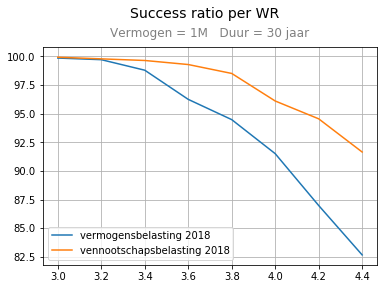

In [11]:
wr_overview.plot(grid=True)
plt.suptitle("Success ratio per WR", y=1.02, fontsize=14)
plt.title("Vermogen = 1M   Duur = 30 jaar", fontsize=12, y=1.02, color='grey')

In [12]:
capital = 1200000 # initial capital
duration = 40 # years
withdrawal_rates = [3, 3.2, 3.4, 3.6, 3.8, 4]

wr_overview = pd.DataFrame(index=withdrawal_rates)
for wr in wr_overview.index:
    
    results = simulate(capital*0.75, wr/100, duration, vermogensbelasting_2018)
    wr_overview.at[wr, 'vermogensbelasting 2018'] = success_rate(results) * 100
    
    results = simulate(capital, wr/100, duration, vennootschapsbelasting)
    wr_overview.at[wr, 'vennootschapsbelasting 2018'] = success_rate(results) * 100
    
wr_overview

,vermogensbelasting 2018,vennootschapsbelasting 2018
3.0,99.690881,99.768161
3.2,98.299845,99.690881
3.4,94.976816,99.304482
3.6,91.421947,98.222566
3.8,84.930448,95.440495
4.0,80.525502,92.272025


Text(0.5, 1.02, 'Vermogen: €1.2M   Duur: 40 jaar')

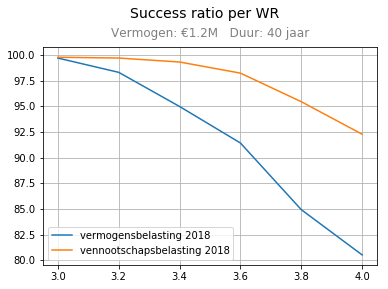

In [13]:
wr_overview.plot(grid=True)
plt.suptitle("Success ratio per WR", y=1.02, fontsize=14)
plt.title("Vermogen: €1.2M   Duur: 40 jaar", fontsize=12, y=1.02, color='grey')